In [1]:
using Revise
using DifferentialEquations
using Flux
using DiffEqFlux
using Optim
using Plots
using FileIO
using JLD2
using OffsetArrays
using Kinetic

In [2]:
function bgk!(df, f, p, t)
    g, tau = p
    df .= (g .- f) ./ tau
end

bgk! (generic function with 1 method)

In [3]:
D = read_dict("../code/shock/shock1D.txt")
for key in keys(D)
    s = Symbol(key)
    @eval $s = $(D[key])
end

case = shock
space = 1d1f1v
nSpecies = 1
interpOrder = 1
limiter = vanleer
cfl = 0.95
maxTime = 250.0
x0 = -25.0
x1 = 25.0
nx = 50
pMeshType = uniform
nxg = 0
umin = -10.0
umax = 10.0
nu = 36
nug = 0
vMeshType = rectangle
knudsen = 1.0
mach = 2.0
prandtl = 1.0
inK = 0.0
omega = 0.5
alphaRef = 1.0
omegaRef = 0.5
tLen = 3
nh = 12



In [4]:
γ = 3.
set = Setup(case, space, nSpecies, interpOrder, limiter, cfl, maxTime)
pSpace = PSpace1D(x0, x1, nx, pMeshType, nxg)
μᵣ = ref_vhs_vis(knudsen, alphaRef, omegaRef)
gas = GasProperty(knudsen, mach, prandtl, inK, γ, omega, alphaRef, omegaRef, μᵣ)
vSpace = VSpace1D(umin, umax, nu, vMeshType, nug)
wL, primL, fL, bcL, wR, primR, fR, bcR = ib_rh(mach, γ, vSpace.u)
ib = IB1D1F(wL, primL, fL, bcL, wR, primR, fR, bcR)

ks = SolverSet(set, pSpace, vSpace, gas, ib, pwd());

In [34]:
ctr = OffsetArray{ControlVolume1D1F}(undef, eachindex(ks.pSpace.x))
face = Array{Interface1D1F}(undef, ks.pSpace.nx+1)
for i in eachindex(ctr)
    if i <= ks.pSpace.nx÷2
        ctr[i] = ControlVolume1D1F(ks.pSpace.x[i], ks.pSpace.dx[i], Float32.(ks.ib.wL), Float32.(ks.ib.primL), Float32.(ks.ib.fL))
    else
        ctr[i] = ControlVolume1D1F(ks.pSpace.x[i], ks.pSpace.dx[i], Float32.(ks.ib.wR), Float32.(ks.ib.primR), Float32.(ks.ib.fR))
    end
end
for i=1:ks.pSpace.nx+1
    face[i] = Interface1D1F(ks.ib.wL, ks.ib.fL)
end

In [6]:
sos = sound_speed(ks.ib.primR, γ)
vmax = ks.vSpace.u1 + sos
tmax = vmax / ks.pSpace.dx[1]
dt = Float32(ks.set.cfl / tmax)
tSpan = (0.f0, dt)
tRan = range(tSpan[1], tSpan[2], length=tLen)

0.0f0:0.03870998f0:0.07741996f0

In [36]:
residual = Array{Float32}(undef, 3)
for iter=1:1000
    Kinetic.evolve!(ks, ctr, face, dt)
    Kinetic.update!(ks, ctr, face, dt, residual)
end

In [8]:
X = Array{Float32}(undef, nu, nx);
for i in 1:nx
    X[:,i] .= ctr[i].f
end

In [9]:
M = Array{Float32}(undef, nu, nx)
τ = Array{Float32}(undef, 1, nx)
for i=1:nx
    M[:,i] .= maxwellian(ks.vSpace.u, ctr[i].prim)
    τ[1,i] = vhs_collision_time(ctr[i].prim, ks.gas.μᵣ, ks.gas.ω)
end

data_para = [M, τ];

In [10]:
prob = ODEProblem(bgk!, X, tSpan, data_para)
Y = solve(prob, Tsit5(), saveat=tRan) |> Array;

In [11]:
dudt = FastChain( (x, p) -> x.^2,
                   FastDense(vSpace.nu, vSpace.nu*16, tanh),
                   #FastDense(vSpace.nu*16, vSpace.nu*16, tanh),
                   FastDense(vSpace.nu*16, vSpace.nu) )
node = NeuralODE(dudt, tSpan, Tsit5(), saveat=tRan);

In [12]:
function loss_node(p) # without dataset
    diff = Array(node(X, p)) .- Y
    loss = sum(abs2, diff)
    return loss
end

loss_node (generic function with 1 method)

In [13]:
cb = function (p, l)
    display(l)
    return false
end

#5 (generic function with 1 method)

In [14]:
#res = DiffEqFlux.sciml_train(loss_node, node.p, ADAM(), dataset, cb=cb, maxiters=100)
res = DiffEqFlux.sciml_train(loss_node, node.p, ADAM(), cb=cb, maxiters=200)

0.0122402795f0

loss: 0.0122:   0%|▎                                        |  ETA: 1:45:31

0.0033408897f0

loss: 0.00334:   1%|▍                                        |  ETA: 0:54:38

0.0018682581f0

loss: 0.00187:   2%|▋                                        |  ETA: 0:36:45

0.0030265476f0

loss: 0.00303:   2%|▉                                        |  ETA: 0:27:43

0.0036801053f0

loss: 0.00368:   2%|█                                        |  ETA: 0:22:17

0.00325077f0

loss: 0.00325:   3%|█▎                                       |  ETA: 0:18:40

0.0023321684f0

loss: 0.00233:   4%|█▍                                       |  ETA: 0:16:05

0.0015230246f0

loss: 0.00152:   4%|█▋                                       |  ETA: 0:14:09

0.0011098892f0

loss: 0.00111:   4%|█▉                                       |  ETA: 0:12:36

0.0010965185f0

loss: 0.0011:   5%|██                                       |  ETA: 0:11:23

0.0013103236f0

loss: 0.00131:   6%|██▎                                      |  ETA: 0:10:25

0.0015368708f0

loss: 0.00154:   6%|██▌                                      |  ETA: 0:09:37

0.0016305924f0

loss: 0.00163:   6%|██▋                                      |  ETA: 0:08:56

0.0015501436f0

loss: 0.00155:   7%|██▉                                      |  ETA: 0:08:20

0.0013298689f0

loss: 0.00133:   8%|███▏                                     |  ETA: 0:07:50

0.0010432681f0

loss: 0.00104:   8%|███▎                                     |  ETA: 0:07:24

0.00077948044f0

loss: 0.000779:   8%|███▌                                     |  ETA: 0:06:58

0.0006159849f0

loss: 0.000616:   9%|███▊                                     |  ETA: 0:06:35

0.0005886305f0

loss: 0.000589:  10%|███▉                                     |  ETA: 0:06:16

0.0006742668f0

loss: 0.000674:  10%|████▏                                    |  ETA: 0:05:57

0.00080015144f0

loss: 0.0008:  10%|████▎                                    |  ETA: 0:05:41

0.00088182965f0

loss: 0.000882:  11%|████▌                                    |  ETA: 0:05:28

0.0008688987f0

loss: 0.000869:  12%|████▊                                    |  ETA: 0:05:16

0.0007675173f0

loss: 0.000768:  12%|████▉                                    |  ETA: 0:05:03

0.00062761f0

loss: 0.000628:  12%|█████▏                                   |  ETA: 0:04:51

0.00051038014f0

loss: 0.00051:  13%|█████▍                                   |  ETA: 0:04:40

0.0004572658f0

loss: 0.000457:  14%|█████▌                                   |  ETA: 0:04:30

0.00047243925f0

loss: 0.000472:  14%|█████▊                                   |  ETA: 0:04:20

0.0005255674f0

loss: 0.000526:  14%|██████                                   |  ETA: 0:04:11

0.0005730018f0

loss: 0.000573:  15%|██████▏                                  |  ETA: 0:04:03

0.00058305176f0

loss: 0.000583:  16%|██████▍                                  |  ETA: 0:03:55

0.00054967194f0

loss: 0.00055:  16%|██████▌                                  |  ETA: 0:03:48

0.0004900624f0

loss: 0.00049:  16%|██████▊                                  |  ETA: 0:03:41

0.0004315977f0

loss: 0.000432:  17%|███████                                  |  ETA: 0:03:34

0.0003967548f0

loss: 0.000397:  18%|███████▏                                 |  ETA: 0:03:28

0.00039297016f0

loss: 0.000393:  18%|███████▍                                 |  ETA: 0:03:22

0.00041099967f0

loss: 0.000411:  18%|███████▋                                 |  ETA: 0:03:17

0.00043229765f0

loss: 0.000432:  19%|███████▊                                 |  ETA: 0:03:12

0.00044058845f0

loss: 0.000441:  20%|████████                                 |  ETA: 0:03:07

0.00042979053f0

loss: 0.00043:  20%|████████▎                                |  ETA: 0:03:02

0.00040483839f0

loss: 0.000405:  20%|████████▍                                |  ETA: 0:02:58

0.00037678913f0

loss: 0.000377:  21%|████████▋                                |  ETA: 0:02:53

0.00035596098f0

loss: 0.000356:  22%|████████▉                                |  ETA: 0:02:49

0.00034696818f0

loss: 0.000347:  22%|█████████                                |  ETA: 0:02:45

0.0003477727f0

loss: 0.000348:  22%|█████████▎                               |  ETA: 0:02:42

0.0003524421f0

loss: 0.000352:  23%|█████████▍                               |  ETA: 0:02:38

0.00035501024f0

loss: 0.000355:  24%|█████████▋                               |  ETA: 0:02:34

0.00035188557f0

loss: 0.000352:  24%|█████████▉                               |  ETA: 0:02:31

0.0003427591f0

loss: 0.000343:  24%|██████████                               |  ETA: 0:02:28

0.00033030746f0

loss: 0.00033:  25%|██████████▎                              |  ETA: 0:02:25

0.00031852862f0

loss: 0.000319:  26%|██████████▌                              |  ETA: 0:02:22

0.00031060306f0

loss: 0.000311:  26%|██████████▋                              |  ETA: 0:02:19

0.00030743593f0

loss: 0.000307:  26%|██████████▉                              |  ETA: 0:02:16

0.00030737283f0

loss: 0.000307:  27%|███████████▏                             |  ETA: 0:02:14

0.0003071401f0

loss: 0.000307:  28%|███████████▎                             |  ETA: 0:02:11

0.00030372466f0

loss: 0.000304:  28%|███████████▌                             |  ETA: 0:02:08

0.00029636547f0

loss: 0.000296:  28%|███████████▋                             |  ETA: 0:02:06

0.00028708085f0

loss: 0.000287:  29%|███████████▉                             |  ETA: 0:02:04

0.0002791072f0

loss: 0.000279:  30%|████████████▏                            |  ETA: 0:02:01

0.0002745092f0

loss: 0.000275:  30%|████████████▎                            |  ETA: 0:01:59

0.00027285804f0

loss: 0.000273:  30%|████████████▌                            |  ETA: 0:01:57

0.00027192396f0

loss: 0.000272:  31%|████████████▊                            |  ETA: 0:01:55

0.00026946107f0

loss: 0.000269:  32%|████████████▉                            |  ETA: 0:01:53

0.00026463612f0

loss: 0.000265:  32%|█████████████▏                           |  ETA: 0:01:51

0.00025830264f0

loss: 0.000258:  32%|█████████████▍                           |  ETA: 0:01:49

0.00025212442f0

loss: 0.000252:  33%|█████████████▌                           |  ETA: 0:01:47

0.00024735596f0

loss: 0.000247:  34%|█████████████▊                           |  ETA: 0:01:45

0.00024414077f0

loss: 0.000244:  34%|██████████████                           |  ETA: 0:01:43

0.00024161325f0

loss: 0.000242:  34%|██████████████▏                          |  ETA: 0:01:42

0.00023866424f0

loss: 0.000239:  35%|██████████████▍                          |  ETA: 0:01:40

0.00023478463f0

loss: 0.000235:  36%|██████████████▌                          |  ETA: 0:01:38

0.0002302568f0

loss: 0.00023:  36%|██████████████▊                          |  ETA: 0:01:37

0.00022566342f0

loss: 0.000226:  36%|███████████████                          |  ETA: 0:01:35

0.00022143382f0

loss: 0.000221:  37%|███████████████▏                         |  ETA: 0:01:33

0.00021774994f0

loss: 0.000218:  38%|███████████████▍                         |  ETA: 0:01:32

0.00021452356f0

loss: 0.000215:  38%|███████████████▋                         |  ETA: 0:01:30

0.00021142495f0

loss: 0.000211:  38%|███████████████▊                         |  ETA: 0:01:29

0.00020806042f0

loss: 0.000208:  39%|████████████████                         |  ETA: 0:01:28

0.00020427536f0

loss: 0.000204:  40%|████████████████▎                        |  ETA: 0:01:26

0.00020026145f0

loss: 0.0002:  40%|████████████████▍                        |  ETA: 0:01:25

0.0001963561f0

loss: 0.000196:  40%|████████████████▋                        |  ETA: 0:01:23

0.00019278804f0

loss: 0.000193:  41%|████████████████▊                        |  ETA: 0:01:22

0.00018956422f0

loss: 0.00019:  42%|█████████████████                        |  ETA: 0:01:21

0.00018647988f0

loss: 0.000186:  42%|█████████████████▎                       |  ETA: 0:01:20

0.00018325576f0

loss: 0.000183:  42%|█████████████████▍                       |  ETA: 0:01:18

0.00017976243f0

loss: 0.00018:  43%|█████████████████▋                       |  ETA: 0:01:17

0.00017613228f0

loss: 0.000176:  44%|█████████████████▉                       |  ETA: 0:01:16

0.00017262418f0

loss: 0.000173:  44%|██████████████████                       |  ETA: 0:01:15

0.0001693807f0

loss: 0.000169:  44%|██████████████████▎                      |  ETA: 0:01:14

0.00016632478f0

loss: 0.000166:  45%|██████████████████▌                      |  ETA: 0:01:13

0.00016328102f0

loss: 0.000163:  46%|██████████████████▋                      |  ETA: 0:01:11

0.00016013246f0

loss: 0.00016:  46%|██████████████████▉                      |  ETA: 0:01:10

0.00015689433f0

loss: 0.000157:  46%|███████████████████▏                     |  ETA: 0:01:09

0.00015367006f0

loss: 0.000154:  47%|███████████████████▎                     |  ETA: 0:01:08

0.00015055199f0

loss: 0.000151:  48%|███████████████████▌                     |  ETA: 0:01:07

0.00014755384f0

loss: 0.000148:  48%|███████████████████▋                     |  ETA: 0:01:06

0.0001446261f0

loss: 0.000145:  48%|███████████████████▉                     |  ETA: 0:01:05

0.00014171029f0

loss: 0.000142:  49%|████████████████████▏                    |  ETA: 0:01:04

0.00013878061f0

loss: 0.000139:  50%|████████████████████▎                    |  ETA: 0:01:03

0.0001358483f0

loss: 0.000136:  50%|████████████████████▌                    |  ETA: 0:01:02

0.00013294545f0

loss: 0.000133:  50%|████████████████████▊                    |  ETA: 0:01:01

0.00013010544f0

loss: 0.00013:  51%|████████████████████▉                    |  ETA: 0:01:00

0.00012734218f0

loss: 0.000127:  52%|█████████████████████▏                   |  ETA: 0:00:59

0.00012464274f0

loss: 0.000125:  52%|█████████████████████▍                   |  ETA: 0:00:58

0.00012197177f0

loss: 0.000122:  52%|█████████████████████▌                   |  ETA: 0:00:57

0.00011930174f0

loss: 0.000119:  53%|█████████████████████▊                   |  ETA: 0:00:57

0.00011664023f0

loss: 0.000117:  54%|█████████████████████▉                   |  ETA: 0:00:56

0.000114021765f0

loss: 0.000114:  54%|██████████████████████▏                  |  ETA: 0:00:55

0.00011147271f0

loss: 0.000111:  54%|██████████████████████▍                  |  ETA: 0:00:54

0.00010898795f0

loss: 0.000109:  55%|██████████████████████▌                  |  ETA: 0:00:53

0.00010654309f0

loss: 0.000107:  56%|██████████████████████▊                  |  ETA: 0:00:52

0.000104116676f0

loss: 0.000104:  56%|███████████████████████                  |  ETA: 0:00:51

0.000101710844f0

loss: 0.000102:  56%|███████████████████████▏                 |  ETA: 0:00:51

9.9344164f-5

loss: 9.93e-05:  57%|███████████████████████▍                 |  ETA: 0:00:50

9.703247f-5

loss: 9.7e-05:  58%|███████████████████████▋                 |  ETA: 0:00:49

9.4774674f-5

loss: 9.48e-05:  58%|███████████████████████▊                 |  ETA: 0:00:48

9.255933f-5

loss: 9.26e-05:  58%|████████████████████████                 |  ETA: 0:00:47

9.037725f-5

loss: 9.04e-05:  59%|████████████████████████▎                |  ETA: 0:00:47

8.82272f-5

loss: 8.82e-05:  60%|████████████████████████▍                |  ETA: 0:00:46

8.6115055f-5

loss: 8.61e-05:  60%|████████████████████████▋                |  ETA: 0:00:45

8.404616f-5

loss: 8.4e-05:  60%|████████████████████████▊                |  ETA: 0:00:44

8.202341f-5

loss: 8.2e-05:  61%|█████████████████████████                |  ETA: 0:00:44

8.004599f-5

loss: 8e-05:  62%|█████████████████████████▎               |  ETA: 0:00:43

7.810865f-5

loss: 7.81e-05:  62%|█████████████████████████▍               |  ETA: 0:00:42

7.620759f-5

loss: 7.62e-05:  62%|█████████████████████████▋               |  ETA: 0:00:41

7.434283f-5

loss: 7.43e-05:  63%|█████████████████████████▉               |  ETA: 0:00:41

7.251834f-5

loss: 7.25e-05:  64%|██████████████████████████               |  ETA: 0:00:40

7.073692f-5

loss: 7.07e-05:  64%|██████████████████████████▎              |  ETA: 0:00:39

6.899904f-5

loss: 6.9e-05:  64%|██████████████████████████▌              |  ETA: 0:00:39

6.730126f-5

loss: 6.73e-05:  65%|██████████████████████████▋              |  ETA: 0:00:38

6.5640015f-5

loss: 6.56e-05:  66%|██████████████████████████▉              |  ETA: 0:00:37

6.4014734f-5

loss: 6.4e-05:  66%|███████████████████████████              |  ETA: 0:00:37

6.242875f-5

loss: 6.24e-05:  66%|███████████████████████████▎             |  ETA: 0:00:36

6.0882932f-5

loss: 6.09e-05:  67%|███████████████████████████▌             |  ETA: 0:00:35

5.9378f-5

loss: 5.94e-05:  68%|███████████████████████████▋             |  ETA: 0:00:35

5.791036f-5

loss: 5.79e-05:  68%|███████████████████████████▉             |  ETA: 0:00:34

5.6478984f-5

loss: 5.65e-05:  68%|████████████████████████████▏            |  ETA: 0:00:33

5.5082586f-5

loss: 5.51e-05:  69%|████████████████████████████▎            |  ETA: 0:00:33

5.3723445f-5

loss: 5.37e-05:  70%|████████████████████████████▌            |  ETA: 0:00:32

5.2401097f-5

loss: 5.24e-05:  70%|████████████████████████████▊            |  ETA: 0:00:31

5.1115854f-5

loss: 5.11e-05:  70%|████████████████████████████▉            |  ETA: 0:00:31

4.986597f-5

loss: 4.99e-05:  71%|█████████████████████████████▏           |  ETA: 0:00:30

4.865018f-5

loss: 4.87e-05:  72%|█████████████████████████████▍           |  ETA: 0:00:30

4.7467307f-5

loss: 4.75e-05:  72%|█████████████████████████████▌           |  ETA: 0:00:29

4.63186f-5

loss: 4.63e-05:  72%|█████████████████████████████▊           |  ETA: 0:00:28

4.520324f-5

loss: 4.52e-05:  73%|█████████████████████████████▉           |  ETA: 0:00:28

4.4120945f-5

loss: 4.41e-05:  74%|██████████████████████████████▏          |  ETA: 0:00:27

4.307148f-5

loss: 4.31e-05:  74%|██████████████████████████████▍          |  ETA: 0:00:27

4.2052932f-5

loss: 4.21e-05:  74%|██████████████████████████████▌          |  ETA: 0:00:26

4.1064868f-5

loss: 4.11e-05:  75%|██████████████████████████████▊          |  ETA: 0:00:25

4.010684f-5

loss: 4.01e-05:  76%|███████████████████████████████          |  ETA: 0:00:25

3.9179085f-5

loss: 3.92e-05:  76%|███████████████████████████████▏         |  ETA: 0:00:24

3.8281098f-5

loss: 3.83e-05:  76%|███████████████████████████████▍         |  ETA: 0:00:24

3.741116f-5

loss: 3.74e-05:  77%|███████████████████████████████▋         |  ETA: 0:00:23

3.6569516f-5

loss: 3.66e-05:  78%|███████████████████████████████▊         |  ETA: 0:00:23

3.5754656f-5

loss: 3.58e-05:  78%|████████████████████████████████         |  ETA: 0:00:22

3.4966295f-5

loss: 3.5e-05:  78%|████████████████████████████████▏        |  ETA: 0:00:21

3.420465f-5

loss: 3.42e-05:  79%|████████████████████████████████▍        |  ETA: 0:00:21

3.346841f-5

loss: 3.35e-05:  80%|████████████████████████████████▋        |  ETA: 0:00:20

3.2757027f-5

loss: 3.28e-05:  80%|████████████████████████████████▊        |  ETA: 0:00:20

3.2069864f-5

loss: 3.21e-05:  80%|█████████████████████████████████        |  ETA: 0:00:19

3.140609f-5

loss: 3.14e-05:  81%|█████████████████████████████████▎       |  ETA: 0:00:19

3.0765532f-5

loss: 3.08e-05:  82%|█████████████████████████████████▍       |  ETA: 0:00:18

3.014739f-5

loss: 3.01e-05:  82%|█████████████████████████████████▋       |  ETA: 0:00:18

2.9551195f-5

loss: 2.96e-05:  82%|█████████████████████████████████▉       |  ETA: 0:00:17

2.8976021f-5

loss: 2.9e-05:  83%|██████████████████████████████████       |  ETA: 0:00:17

2.8421242f-5

loss: 2.84e-05:  84%|██████████████████████████████████▎      |  ETA: 0:00:16

2.7886766f-5

loss: 2.79e-05:  84%|██████████████████████████████████▌      |  ETA: 0:00:15

2.737159f-5

loss: 2.74e-05:  84%|██████████████████████████████████▋      |  ETA: 0:00:15

2.6875226f-5

loss: 2.69e-05:  85%|██████████████████████████████████▉      |  ETA: 0:00:14

2.6397376f-5

loss: 2.64e-05:  86%|███████████████████████████████████      |  ETA: 0:00:14

2.5937154f-5

loss: 2.59e-05:  86%|███████████████████████████████████▎     |  ETA: 0:00:13

2.5493893f-5

loss: 2.55e-05:  86%|███████████████████████████████████▌     |  ETA: 0:00:13

2.506744f-5

loss: 2.51e-05:  87%|███████████████████████████████████▋     |  ETA: 0:00:12

2.4656983f-5

loss: 2.47e-05:  88%|███████████████████████████████████▉     |  ETA: 0:00:12

2.4262108f-5

loss: 2.43e-05:  88%|████████████████████████████████████▏    |  ETA: 0:00:11

2.3882185f-5

loss: 2.39e-05:  88%|████████████████████████████████████▎    |  ETA: 0:00:11

2.3516872f-5

loss: 2.35e-05:  89%|████████████████████████████████████▌    |  ETA: 0:00:10

2.3165772f-5

loss: 2.32e-05:  90%|████████████████████████████████████▊    |  ETA: 0:00:10

2.2828093f-5

loss: 2.28e-05:  90%|████████████████████████████████████▉    |  ETA: 0:00:09

2.250382f-5

loss: 2.25e-05:  90%|█████████████████████████████████████▏   |  ETA: 0:00:09

2.2191643f-5

loss: 2.22e-05:  91%|█████████████████████████████████████▎   |  ETA: 0:00:08

2.189204f-5

loss: 2.19e-05:  92%|█████████████████████████████████████▌   |  ETA: 0:00:08

2.1604112f-5

loss: 2.16e-05:  92%|█████████████████████████████████████▊   |  ETA: 0:00:07

2.132753f-5

loss: 2.13e-05:  92%|█████████████████████████████████████▉   |  ETA: 0:00:07

2.106177f-5

loss: 2.11e-05:  93%|██████████████████████████████████████▏  |  ETA: 0:00:07

2.0806692f-5

loss: 2.08e-05:  94%|██████████████████████████████████████▍  |  ETA: 0:00:06

2.0561612f-5

loss: 2.06e-05:  94%|██████████████████████████████████████▌  |  ETA: 0:00:06

2.0326237f-5

loss: 2.03e-05:  94%|██████████████████████████████████████▊  |  ETA: 0:00:05

2.010028f-5

loss: 2.01e-05:  95%|███████████████████████████████████████  |  ETA: 0:00:05

1.9883395f-5

loss: 1.99e-05:  96%|███████████████████████████████████████▏ |  ETA: 0:00:04

1.9675279f-5

loss: 1.97e-05:  96%|███████████████████████████████████████▍ |  ETA: 0:00:04

1.947528f-5

loss: 1.95e-05:  96%|███████████████████████████████████████▋ |  ETA: 0:00:03

1.9283412f-5

loss: 1.93e-05:  97%|███████████████████████████████████████▊ |  ETA: 0:00:03

1.9099254f-5

loss: 1.91e-05:  98%|████████████████████████████████████████ |  ETA: 0:00:02

1.8922494f-5

loss: 1.89e-05:  98%|████████████████████████████████████████▏|  ETA: 0:00:02

1.8752839f-5

loss: 1.88e-05:  98%|████████████████████████████████████████▍|  ETA: 0:00:01

1.8589999f-5

loss: 1.86e-05:  99%|████████████████████████████████████████▋|  ETA: 0:00:01

1.843366f-5

loss: 1.84e-05: 100%|████████████████████████████████████████▊|  ETA: 0:00:00

1.8283805f-5

loss: 1.83e-05: 100%|█████████████████████████████████████████| Time: 0:01:30


1.8283805f-5

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Minimizer: [-2.78e-02, -4.66e-02, 3.97e-02,  ...]
    Minimum:   1.828380e-05

 * Found with
    Algorithm:     ADAM
    Initial Point: [-2.81e-02, -4.79e-02, 3.89e-02,  ...]

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   91  (vs limit Inf)
    Iterations:    200
    f(x) calls:    200
    ∇f(x) calls:   200


In [158]:
#res = DiffEqFlux.sciml_train(loss_node, res.minimizer, ADAM(), dataset, cb=Flux.throttle(cb, 1), maxiters=1000)
res = DiffEqFlux.sciml_train(loss_node, res.minimizer, ADAM(), cb=Flux.throttle(cb, 1), maxiters=400)

6.947397f0

loss: 5.1:   0%|▎                                        |  ETA: 0:34:23m

3.8722093f0

loss: 3.22:   1%|▍                                        |  ETA: 0:21:15

3.170754f0

loss: 3.26:   2%|▋                                        |  ETA: 0:17:11

3.048909f0

loss: 2.6:   2%|▉                                        |  ETA: 0:15:11m

2.3492167f0

loss: 2.09:   2%|█                                        |  ETA: 0:13:54

1.7699149f0

loss: 1.63:   3%|█▎                                       |  ETA: 0:13:09

1.5426803f0

loss: 1.45:   4%|█▍                                       |  ETA: 0:12:29

1.3658637f0

loss: 1.31:   4%|█▋                                       |  ETA: 0:11:58

1.1367986f0

loss: 0.851:   4%|█▉                                       |  ETA: 0:11:35

0.8276946f0

loss: 0.945:   5%|██                                       |  ETA: 0:11:08

0.9953926f0

loss: 1.04:   6%|██▎                                      |  ETA: 0:10:52m

1.0111159f0

loss: 0.909:   6%|██▌                                      |  ETA: 0:10:34

0.8483271f0

loss: 0.813:   6%|██▋                                      |  ETA: 0:10:26

0.7374777f0

loss: 0.651:   7%|██▉                                      |  ETA: 0:10:09

0.5765276f0

loss: 0.615:   8%|███▏                                     |  ETA: 0:09:58

0.5536214f0

loss: 0.543:   8%|███▎                                     |  ETA: 0:09:49

0.6087866f0

loss: 0.607:   8%|███▌                                     |  ETA: 0:09:41

0.54719275f0

loss: 0.497:   9%|███▊                                     |  ETA: 0:09:32

0.49648258f0

loss: 0.459:  10%|███▉                                     |  ETA: 0:09:30

0.40943378f0

loss: 0.417:  10%|████▏                                    |  ETA: 0:09:24

0.4409938f0

loss: 0.455:  10%|████▎                                    |  ETA: 0:09:16

0.40113837f0

loss: 0.386:  11%|████▌                                    |  ETA: 0:09:07

0.38787982f0

loss: 0.384:  12%|████▊                                    |  ETA: 0:08:59

0.4333429f0

loss: 0.403:  12%|████▉                                    |  ETA: 0:08:51

0.33057463f0

loss: 0.386:  12%|█████▏                                   |  ETA: 0:08:43

0.41279897f0

loss: 0.328:  13%|█████▍                                   |  ETA: 0:08:35

0.33391726f0

loss: 0.321:  14%|█████▊                                   |  ETA: 0:08:22

0.33224878f0

loss: 0.332:  14%|██████                                   |  ETA: 0:08:15

0.31760967f0

loss: 0.353:  15%|██████▏                                  |  ETA: 0:08:09

0.35767063f0

loss: 0.342:  16%|██████▍                                  |  ETA: 0:08:05

0.3023101f0

loss: 0.311:  16%|██████▌                                  |  ETA: 0:08:00

0.35905308f0

loss: 0.338:  16%|██████▊                                  |  ETA: 0:07:55

0.3134349f0

loss: 0.31:  17%|███████                                  |  ETA: 0:07:51m

0.30736643f0

loss: 0.36:  18%|███████▏                                 |  ETA: 0:07:48m

0.28677034f0

loss: 0.372:  18%|███████▍                                 |  ETA: 0:07:44

0.34990832f0

loss: 0.316:  18%|███████▋                                 |  ETA: 0:07:40

0.33498567f0

loss: 0.286:  19%|███████▊                                 |  ETA: 0:07:38

0.31928322f0

loss: 0.323:  20%|████████                                 |  ETA: 0:07:34

0.30050802f0

loss: 0.359:  20%|████████▎                                |  ETA: 0:07:30

0.3086906f0

loss: 0.343:  20%|████████▍                                |  ETA: 0:07:27

0.33978072f0

loss: 0.291:  21%|████████▋                                |  ETA: 0:07:22

0.33343688f0

loss: 0.309:  22%|████████▉                                |  ETA: 0:07:19

0.3108423f0

loss: 0.293:  22%|█████████                                |  ETA: 0:07:16

0.3123893f0

loss: 0.309:  22%|█████████▎                               |  ETA: 0:07:13

0.29737148f0

loss: 0.277:  23%|█████████▍                               |  ETA: 0:07:09

0.29024988f0

loss: 0.307:  24%|█████████▋                               |  ETA: 0:07:06

0.27406108f0

loss: 0.325:  24%|█████████▉                               |  ETA: 0:07:02

0.33548537f0

loss: 0.343:  24%|██████████                               |  ETA: 0:06:59

0.29179993f0

loss: 0.338:  25%|██████████▎                              |  ETA: 0:06:54

0.29929352f0

loss: 0.329:  26%|██████████▌                              |  ETA: 0:06:50

0.29738244f0

loss: 0.294:  26%|██████████▋                              |  ETA: 0:06:49

0.31047866f0

loss: 0.288:  26%|██████████▉                              |  ETA: 0:06:46

0.28201693f0

loss: 0.257:  27%|███████████▏                             |  ETA: 0:06:42

0.27893877f0

loss: 0.287:  28%|███████████▎                             |  ETA: 0:06:39

0.2616891f0

loss: 0.289:  28%|███████████▌                             |  ETA: 0:06:36

0.31003982f0

loss: 0.269:  28%|███████████▋                             |  ETA: 0:06:33

0.281905f0

loss: 0.282:  29%|███████████▉                             |  ETA: 0:06:30

0.26078522f0

loss: 0.265:  30%|████████████▏                            |  ETA: 0:06:26

0.24991211f0

loss: 0.28:  30%|████████████▎                            |  ETA: 0:06:23

0.2915981f0

loss: 0.27:  30%|████████████▌                            |  ETA: 0:06:20m

0.25010115f0

loss: 0.268:  31%|████████████▊                            |  ETA: 0:06:16

0.25171822f0

loss: 0.259:  32%|████████████▉                            |  ETA: 0:06:13

0.2972566f0

loss: 0.297:  32%|█████████████▏                           |  ETA: 0:06:09

0.27719265f0

loss: 0.271:  32%|█████████████▍                           |  ETA: 0:06:06

0.29343468f0

loss: 0.325:  33%|█████████████▌                           |  ETA: 0:06:03

0.31980065f0

loss: 0.354:  34%|█████████████▊                           |  ETA: 0:06:01

0.31085175f0

loss: 0.279:  34%|██████████████                           |  ETA: 0:05:58

0.31872326f0

loss: 0.321:  34%|██████████████▏                          |  ETA: 0:05:56

0.27454597f0

loss: 0.295:  35%|██████████████▍                          |  ETA: 0:05:53

0.3132395f0

loss: 0.295:  36%|██████████████▋                          |  ETA: 0:05:49

0.2708866f0

loss: 0.311:  36%|██████████████▉                          |  ETA: 0:05:45

0.3094378f0

loss: 0.275:  37%|███████████████                          |  ETA: 0:05:42

0.3068648f0

loss: 0.294:  37%|███████████████▎                         |  ETA: 0:05:39

0.2952526f0

loss: 0.313:  38%|███████████████▋                         |  ETA: 0:05:33

0.29303414f0

loss: 0.288:  38%|███████████████▊                         |  ETA: 0:05:30

0.30700964f0

loss: 0.297:  39%|████████████████                         |  ETA: 0:05:27

0.31200668f0

loss: 0.296:  40%|████████████████▎                        |  ETA: 0:05:25

0.30292368f0

loss: 0.32:  40%|████████████████▍                        |  ETA: 0:05:22m

0.27410737f0

loss: 0.264:  40%|████████████████▋                        |  ETA: 0:05:20

0.2933251f0

loss: 0.27:  41%|████████████████▊                        |  ETA: 0:05:16m

0.27382785f0

loss: 0.279:  42%|█████████████████                        |  ETA: 0:05:14

0.2843734f0

loss: 0.327:  42%|█████████████████▎                       |  ETA: 0:05:12

0.31272578f0

loss: 0.288:  42%|█████████████████▍                       |  ETA: 0:05:09

0.29552317f0

loss: 0.297:  43%|█████████████████▋                       |  ETA: 0:05:06

0.32867938f0

loss: 0.308:  44%|█████████████████▉                       |  ETA: 0:05:03

0.3398861f0

loss: 0.295:  44%|██████████████████                       |  ETA: 0:05:00

0.35336655f0

loss: 0.309:  44%|██████████████████▎                      |  ETA: 0:04:59

0.37073112f0

loss: 0.369:  45%|██████████████████▌                      |  ETA: 0:04:56

0.32636693f0

loss: 0.328:  46%|██████████████████▋                      |  ETA: 0:04:54

0.34526762f0

loss: 0.353:  46%|██████████████████▉                      |  ETA: 0:04:51

0.28513923f0

loss: 0.339:  46%|███████████████████▏                     |  ETA: 0:04:48

0.31449482f0

loss: 0.32:  47%|███████████████████▎                     |  ETA: 0:04:45m

0.29050288f0

loss: 0.325:  48%|███████████████████▌                     |  ETA: 0:04:42

0.29658f0

loss: 0.296:  48%|███████████████████▋                     |  ETA: 0:04:39

0.2656078f0

loss: 0.322:  48%|███████████████████▉                     |  ETA: 0:04:36

0.32288608f0

loss: 0.289:  49%|████████████████████▏                    |  ETA: 0:04:33

0.33361515f0

loss: 0.307:  50%|████████████████████▎                    |  ETA: 0:04:31

0.24859208f0

loss: 0.295:  50%|████████████████████▌                    |  ETA: 0:04:27

0.30426547f0

loss: 0.294:  50%|████████████████████▊                    |  ETA: 0:04:25

0.303321f0

loss: 0.305:  51%|████████████████████▉                    |  ETA: 0:04:22

0.3089534f0

loss: 0.3:  52%|█████████████████████▏                   |  ETA: 0:04:199m

0.33775955f0

loss: 0.3:  52%|█████████████████████▍                   |  ETA: 0:04:179m

0.31304985f0

loss: 0.338:  52%|█████████████████████▌                   |  ETA: 0:04:14

0.30868703f0

loss: 0.337:  53%|█████████████████████▊                   |  ETA: 0:04:11

0.32247674f0

loss: 0.33:  54%|█████████████████████▉                   |  ETA: 0:04:09m

0.28567508f0

loss: 0.302:  54%|██████████████████████▏                  |  ETA: 0:04:06

0.30142036f0

loss: 0.279:  54%|██████████████████████▍                  |  ETA: 0:04:03

0.24619249f0

loss: 0.267:  55%|██████████████████████▌                  |  ETA: 0:04:00

0.3069125f0

loss: 0.259:  56%|██████████████████████▉                  |  ETA: 0:03:56

0.25506407f0

loss: 0.306:  56%|███████████████████████▏                 |  ETA: 0:03:52

0.26626006f0

loss: 0.276:  57%|███████████████████████▍                 |  ETA: 0:03:49

0.29753542f0

loss: 0.283:  58%|███████████████████████▋                 |  ETA: 0:03:46

0.25775355f0

loss: 0.268:  58%|███████████████████████▊                 |  ETA: 0:03:43

0.277458f0

loss: 0.289:  58%|████████████████████████                 |  ETA: 0:03:40

0.27617228f0

loss: 0.274:  59%|████████████████████████▎                |  ETA: 0:03:36

0.30293787f0

loss: 0.246:  60%|████████████████████████▋                |  ETA: 0:03:32

0.28544733f0

loss: 0.249:  61%|████████████████████████▉                |  ETA: 0:03:28

0.26599014f0

loss: 0.289:  61%|█████████████████████████▏               |  ETA: 0:03:25

0.30366975f0

loss: 0.262:  62%|█████████████████████████▍               |  ETA: 0:03:20

0.2697288f0

loss: 0.274:  62%|█████████████████████████▋               |  ETA: 0:03:18

0.27152586f0

loss: 0.284:  63%|█████████████████████████▉               |  ETA: 0:03:15

0.2661202f0

loss: 0.306:  64%|██████████████████████████               |  ETA: 0:03:12

0.30635244f0

loss: 0.287:  64%|██████████████████████████▎              |  ETA: 0:03:09

0.2722914f0

loss: 0.271:  64%|██████████████████████████▌              |  ETA: 0:03:07

0.27848503f0

loss: 0.303:  65%|██████████████████████████▋              |  ETA: 0:03:04

0.2858426f0

loss: 0.311:  66%|██████████████████████████▉              |  ETA: 0:03:01

0.3156957f0

loss: 0.291:  66%|███████████████████████████              |  ETA: 0:02:59

0.3021489f0

loss: 0.324:  66%|███████████████████████████▎             |  ETA: 0:02:56

0.32523698f0

loss: 0.309:  67%|███████████████████████████▌             |  ETA: 0:02:53

0.26714683f0

loss: 0.279:  68%|███████████████████████████▋             |  ETA: 0:02:51

0.30085322f0

loss: 0.271:  68%|███████████████████████████▉             |  ETA: 0:02:48

0.28677717f0

loss: 0.285:  68%|████████████████████████████▏            |  ETA: 0:02:45

0.27582383f0

loss: 0.325:  69%|████████████████████████████▎            |  ETA: 0:02:42

0.3048806f0

loss: 0.311:  70%|████████████████████████████▌            |  ETA: 0:02:40

0.29378855f0

loss: 0.309:  70%|████████████████████████████▊            |  ETA: 0:02:37

0.29082638f0

loss: 0.275:  70%|████████████████████████████▉            |  ETA: 0:02:35

0.30446917f0

loss: 0.305:  71%|█████████████████████████████▏           |  ETA: 0:02:32

0.28955346f0

loss: 0.298:  72%|█████████████████████████████▍           |  ETA: 0:02:29

0.30696028f0

loss: 0.312:  72%|█████████████████████████████▌           |  ETA: 0:02:27

0.25950164f0

loss: 0.261:  72%|█████████████████████████████▊           |  ETA: 0:02:24

0.29475158f0

loss: 0.289:  73%|█████████████████████████████▉           |  ETA: 0:02:21

0.27277488f0

loss: 0.278:  74%|██████████████████████████████▏          |  ETA: 0:02:19

0.26108533f0

loss: 0.276:  74%|██████████████████████████████▍          |  ETA: 0:02:16

0.2917074f0

loss: 0.272:  74%|██████████████████████████████▌          |  ETA: 0:02:14

0.31367993f0

loss: 0.333:  75%|██████████████████████████████▊          |  ETA: 0:02:11

0.2849202f0

loss: 0.324:  76%|███████████████████████████████          |  ETA: 0:02:08

0.30202985f0

loss: 0.291:  76%|███████████████████████████████▏         |  ETA: 0:02:06

0.2880144f0

loss: 0.312:  76%|███████████████████████████████▍         |  ETA: 0:02:03

0.27826202f0

loss: 0.3:  77%|███████████████████████████████▋         |  ETA: 0:02:009m

0.3243587f0

loss: 0.29:  78%|███████████████████████████████▊         |  ETA: 0:01:58m

0.26837593f0

loss: 0.277:  78%|████████████████████████████████         |  ETA: 0:01:54

0.26901212f0

loss: 0.29:  79%|████████████████████████████████▎        |  ETA: 0:01:51m

0.26985052f0

loss: 0.268:  79%|████████████████████████████████▌        |  ETA: 0:01:49

0.29397413f0

loss: 0.273:  80%|████████████████████████████████▋        |  ETA: 0:01:46

0.22160473f0

loss: 0.24:  80%|████████████████████████████████▉        |  ETA: 0:01:43m

0.27437788f0

loss: 0.26:  81%|█████████████████████████████████▏       |  ETA: 0:01:41m

0.26027548f0

loss: 0.293:  81%|█████████████████████████████████▎       |  ETA: 0:01:38

0.26247302f0

loss: 0.283:  82%|█████████████████████████████████▌       |  ETA: 0:01:36

0.30625656f0

loss: 0.333:  82%|█████████████████████████████████▊       |  ETA: 0:01:33

0.30293712f0

loss: 0.319:  83%|█████████████████████████████████▉       |  ETA: 0:01:30

0.3029621f0

loss: 0.32:  83%|██████████████████████████████████▏      |  ETA: 0:01:28m

0.2867033f0

loss: 0.282:  84%|██████████████████████████████████▍      |  ETA: 0:01:25

0.30121896f0

loss: 0.305:  84%|██████████████████████████████████▌      |  ETA: 0:01:23

0.26933023f0

loss: 0.263:  85%|██████████████████████████████████▊      |  ETA: 0:01:20

0.26836425f0

loss: 0.288:  85%|██████████████████████████████████▉      |  ETA: 0:01:17

0.2825969f0

loss: 0.317:  86%|███████████████████████████████████▏     |  ETA: 0:01:15

0.29206413f0

loss: 0.331:  86%|███████████████████████████████████▍     |  ETA: 0:01:12

0.28383747f0

loss: 0.313:  87%|███████████████████████████████████▌     |  ETA: 0:01:10

0.2800381f0

loss: 0.263:  87%|███████████████████████████████████▊     |  ETA: 0:01:07

0.26926905f0

loss: 0.278:  88%|████████████████████████████████████     |  ETA: 0:01:04

0.2662758f0

loss: 0.265:  88%|████████████████████████████████████▏    |  ETA: 0:01:02

0.25527835f0

loss: 0.28:  89%|████████████████████████████████████▍    |  ETA: 0:00:59m

0.23195311f0

loss: 0.24:  89%|████████████████████████████████████▋    |  ETA: 0:00:57m

0.273049f0

loss: 0.223:  90%|████████████████████████████████████▊    |  ETA: 0:00:54

0.2111211f0

loss: 0.256:  90%|█████████████████████████████████████    |  ETA: 0:00:51

0.23323846f0

loss: 0.22:  91%|█████████████████████████████████████▏   |  ETA: 0:00:49m

0.22832876f0

loss: 0.267:  91%|█████████████████████████████████████▍   |  ETA: 0:00:46

0.23251835f0

loss: 0.252:  92%|█████████████████████████████████████▊   |  ETA: 0:00:42

0.27661693f0

loss: 0.252:  92%|█████████████████████████████████████▉   |  ETA: 0:00:39

0.24302034f0

loss: 0.275:  93%|██████████████████████████████████████▏  |  ETA: 0:00:36

0.28300062f0

loss: 0.254:  94%|██████████████████████████████████████▍  |  ETA: 0:00:34

0.2478278f0

loss: 0.226:  94%|██████████████████████████████████████▌  |  ETA: 0:00:31

0.24883929f0

loss: 0.254:  94%|██████████████████████████████████████▊  |  ETA: 0:00:29

0.23691732f0

loss: 0.248:  95%|███████████████████████████████████████  |  ETA: 0:00:26

0.26006064f0

loss: 0.256:  96%|███████████████████████████████████████▏ |  ETA: 0:00:23

0.25978523f0

loss: 0.32:  96%|███████████████████████████████████████▌ |  ETA: 0:00:20m

0.27111977f0

loss: 0.265:  97%|███████████████████████████████████████▊ |  ETA: 0:00:16

0.28277308f0

loss: 0.268:  98%|████████████████████████████████████████ |  ETA: 0:00:13

0.24653605f0

loss: 0.286:  98%|████████████████████████████████████████▎|  ETA: 0:00:09

0.27994475f0

loss: 0.252:  99%|████████████████████████████████████████▌|  ETA: 0:00:07

0.2723713f0

loss: 0.269:  99%|████████████████████████████████████████▋|  ETA: 0:00:04

0.26261923f0

loss: 0.275: 100%|████████████████████████████████████████▉|  ETA: 0:00:02

0.31243846f0

loss: 0.312: 100%|█████████████████████████████████████████| Time: 0:08:41


 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Minimizer: [-6.09e-02, 9.54e-02, -9.65e-03,  ...]
    Minimum:   3.124385e-01

 * Found with
    Algorithm:     ADAM
    Initial Point: [-4.69e-02, 7.89e-02, -2.35e-02,  ...]

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   522  (vs limit Inf)
    Iterations:    400
    f(x) calls:    400
    ∇f(x) calls:   400


In [17]:
res = DiffEqFlux.sciml_train(loss_node, res.minimizer, LBFGS(), cb=cb, maxiters=200)

1.3207211f-5

1.3162783f-5

1.313933f-5

1.3088811f-5

1.301874f-5

1.3011358f-5

1.3006225f-5

1.2951696f-5

1.2921901f-5

1.2909172f-5

1.2664747f-5

1.2542227f-5

1.2470489f-5

1.1927175f-5

1.1642773f-5

1.1634623f-5

1.1631764f-5

1.1616154f-5

1.1611977f-5

1.1611f-5

1.1610422f-5

1.15993025f-5

1.1593158f-5

1.15910325f-5

1.1538402f-5

1.1289575f-5

1.126679f-5

1.1251149f-5

1.1199305f-5

1.1194721f-5

1.1193894f-5

1.1192406f-5

1.118635f-5

1.1185105f-5

1.1184296f-5

1.1175851f-5

1.1163715f-5

1.1160015f-5

1.113504f-5

1.11132185f-5

1.0946858f-5

1.0486636f-5

1.0344167f-5

1.0259867f-5

9.747035f-6

8.142082f-6

7.878415f-6

7.794866f-6

7.514024f-6

7.4101185f-6

7.3938227f-6

7.361988f-6

7.3392684f-6

7.3307647f-6

7.3141205f-6

7.282902f-6

7.2752255f-6

7.2633f-6

7.2328166f-6

7.2108883f-6

7.163193f-6

7.101204f-6

7.040992f-6

6.9245893f-6

6.8788104f-6

6.792423f-6

6.6357325f-6

 * Status: failure

 * Candidate solution
    Minimizer: [-2.78e-02, -4.66e-02, 3.97e-02,  ...]
    Minimum:   6.635732e-06

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [-2.78e-02, -4.66e-02, 3.97e-02,  ...]

 * Convergence measures
    |x - x'|               = 2.13e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.32e-03 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.57e-07 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.36e-02 ≰ 0.0e+00
    |g(x)|                 = 8.29e-05 ≰ 1.0e-08

 * Work counters
    Seconds run:   60  (vs limit Inf)
    Iterations:    66
    f(x) calls:    202
    ∇f(x) calls:   202


In [18]:
function step_train!( fwL, ffL, w, prim, f, fwR, ffR,
			           γ, μ, ω, u, n_ode, p, dx, tRan, RES, AVG )
    #--- record W^{n} ---#
    w_old = deepcopy(w)
    M = maxwellian(u, prim)
	τ = vhs_collision_time(prim, μ, ω)
    
    #--- update W^{n+1} ---#
	@. w += (fwL - fwR) / dx
	prim .= conserve_prim(w, γ)

	#--- record residuals ---#
	@. RES += (w - w_old)^2
	@. AVG += abs(w)

    data = solve(ODEProblem(bgk!, f[1:end], tSpan, [M, τ]), Tsit5(), saveat=tRan) |> Array;
    pred = n_ode(f[1:end], p) |> Array
    loss = sum(abs2, pred .- data)

    if loss <= 1.e-6
        ftemp = n_ode(f[1:end], p).u[end]
    	for i in eachindex(u)
    		f[i] = ftemp[i] + (ffL[i] - ffR[i]) / dx
    	end
    else
        for i in eachindex(u)
    		f[i] += (ffL[i] - ffR[i]) / dx + (M[i] - f[i]) / τ * tRan[end]
    	end
        
        #push!(datainit, f[1:end])
        #push!(dataset, data)
    end
end

function step_bgk!( fwL, ffL, w, prim, f, fwR, ffR,
			           γ, μ, ω, u, weights, n_ode, p, dx, tRan, RES, AVG )
    
    #--- record W^{n} ---#
    w_old = deepcopy(w)
    prim_old = deepcopy(prim)
    
    #--- update W^{n+1} ---#
	@. w = w_old + (fwL - fwR) / dx
	prim .= conserve_prim(w, γ)

	#--- record residuals ---#
	@. RES += (w - w_old)^2
	@. AVG += abs(w)
    
    M = maxwellian(u, prim_old)
	τ = vhs_collision_time(prim_old, μ, ω)
    
    #ftemp = f .+ (M .- f) / τ * tRan[end]
    prob = ODEProblem(bgk!, f[1:end], (0, tRan[end]), (M, τ))
    ftemp = (solve(prob, Tsit5(), saveat=tRan) |> Array)[:,end]
    
    for i in eachindex(u)
        f[i] = ftemp[i] + (ffL[i] - ffR[i]) / dx
    end
    
end

function step_node!( fwL, ffL, w, prim, f, fwR, ffR,
			           γ, μ, ω, u, weights, n_ode, p, dx, tRan, RES, AVG )
    
    #--- record W^{n} ---#
    w_old = deepcopy(w)
    M = maxwellian(u, prim)
	τ = vhs_collision_time(prim, μ, ω)
    
    #--- update W^{n+1} ---#
	@. w += (fwL - fwR) / dx
	prim .= conserve_prim(w, γ)

	#--- record residuals ---#
	@. RES += (w - w_old)^2
	@. AVG += abs(w)

    ftemp = n_ode(f[1:end], p).u[end]
    for i in eachindex(u)
        f[i] = ftemp[i] + (ffL[i] - ffR[i]) / dx
    end
    
    #w .= moments_conserve( f, u, weights )
    #prim .= conserve_prim(w, γ)

end

step_node! (generic function with 1 method)

In [52]:
sumRes = zeros(Float32, axes(ib.wL))
sumAvg = zeros(Float32, axes(ib.wL))

for iter = 1:1
    Kinetic.evolve!(ks, ctr, face, dt)

    for i in 2:49
        step_node!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
                     face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, vSpace.weights, node, res.minimizer,
                     ctr[i].dx, tRan, sumRes, sumAvg )
    end
end


for iter = 1:1
    Kinetic.evolve!(ks, ctr, face, dt)

    for i in 2:49
        step_node!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
                     face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, vSpace.weights, node, res.minimizer,
                     ctr[i].dx, tRan, sumRes, sumAvg )
    end
end

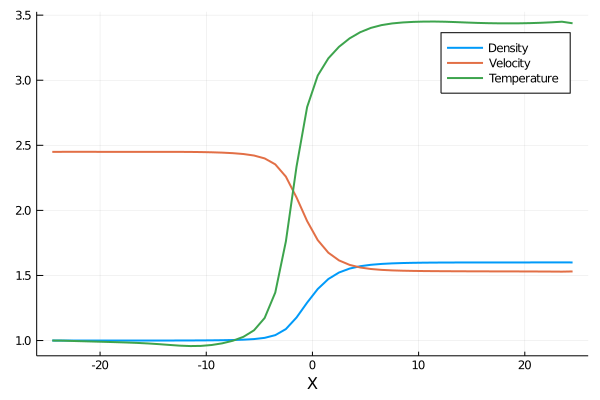

In [53]:
plot_line(ks, ctr)

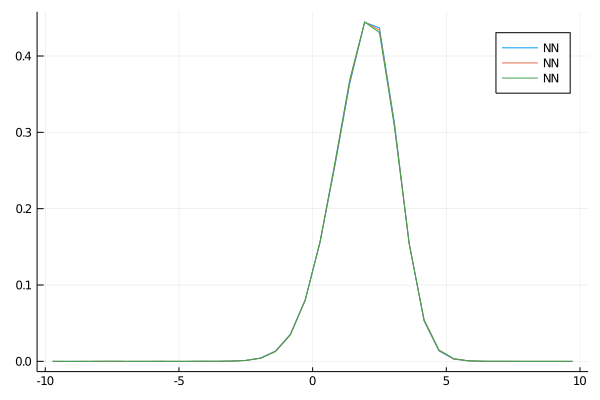

In [20]:
plot(vSpace.u, node(ctr[25].f[1:end], res.minimizer).u, label="NN")

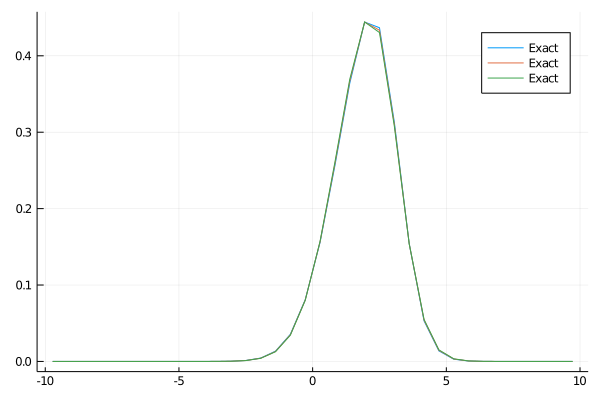

In [21]:
plot(vSpace.u, Y[:,25,:], label="Exact")

In [199]:
X

36×50 Array{Float32,2}:
 0.0          1.7299e-18   1.89053e-18  …  4.88097e-17  4.88119e-17
 0.0          5.21038e-17  5.72352e-17     1.69515e-15  1.69522e-15
 0.0          1.29123e-15  1.4266e-15      4.91952e-14  4.91972e-14
 0.0          2.62526e-14  2.91947e-14     1.19303e-12  1.19307e-12
 5.74532e-44  4.363e-13    4.88817e-13     2.41763e-11  2.41771e-11
 2.671e-39    5.899e-12    6.66586e-12  …  4.09393e-10  4.09406e-10
 6.69376e-35  6.44811e-11  7.35925e-11     5.79301e-9   5.79318e-9 
 9.04864e-31  5.65036e-10  6.52481e-10     6.84983e-8   6.85002e-8 
 6.59802e-27  3.92314e-9   4.5942e-9       6.76811e-7   6.76829e-7 
 2.59514e-23  2.12259e-8   2.52838e-8      5.58815e-6   5.58828e-6 
 5.50585e-20  8.73134e-8   1.06231e-7   …  3.8555e-5    3.85558e-5 
 6.30094e-17  2.62868e-7   3.28585e-7      0.000222282  0.000222286
 3.88959e-14  5.44241e-7   7.05038e-7      0.00107088   0.0010709  
 ⋮                                      ⋱                          
 0.146354     0.146356  